
# Classification with Python
Hopefully now you are feeling a bit more comfortable with Python, Kaggle, and modeling.

This next homework will test your classification abilities. We will be trying to predict whether a person survived the Titantic:

https://www.kaggle.com/c/titanic

The evalution metric for Kaggle is accuracy, but please also explore how well your model does on multiple metrics like F1, precision, recall, and area under the ROC curve.

Grading
This homework is due March 8, 2018 by midnight Utah time. By that time, you need to have committed all your code to your github and submitted a link to your work to the TA. We can see on your Github account when you last committed code. :)

### Rubric:

Code Quality - 10%

Storytelling - 10%

Result on Kaggle - 5%

Describing, Cleaning, and Visualizing data - 25%

Modeling - 50%

More specifically, for modeling we will look for:

Model Selection: Did you try multiple models? Why did you choose these models? How do they work? What are they assumptions? And how did you test/account for them? How did you select hyper-parameters?
Model evaluation: Did you evaluate your model on multiple metrics? Where does your model do well? Where could it be improved? How are the metrics different?
Model interpretation: What do the model results tell you? Which variables are important? High bias or variance and how did you / could you fix this? How confident are you in your results?
Model usefulness: Do you think your final model was useful? If so, how would you recommend using it? Convince us, that if we were a company, we would feel comfortable using your model with our users. Think about edge cases as well - are there certain areas that the model performs poorly on? Best on? How would you handle these cases, if say Zillow wanted to leverage your model realizing that bad recommendations on sale prices would hurt customer trust and your brand. This section also falls into the storytelling aspect of the grading.

In [729]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import SGDRegressor
import seaborn as sns
from scipy import stats
%matplotlib inline

Let's read in the data to see what we have to work with.

In [730]:
train = pd.read_csv('train.csv')
test= pd.read_csv('test.csv')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


From a cursory look at my variables, I suspect class, sex, age, sibling/spouse, parent/child, and ticket fare to be important determinants of survival on the titanic.  I will examine the remaining variables to determine whether their inclusion is justified.

## Data Cleaning

In [731]:
train.describe().round(2)

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.00,891.00,891.00,714.00,891.00,891.00,891.00
mean,446.00,0.38,2.31,29.70,0.52,0.38,32.20
std,257.35,0.49,0.84,14.53,1.10,0.81,49.69
min,1.00,0.00,1.00,0.42,0.00,0.00,0.00
25%,223.50,0.00,2.00,20.12,0.00,0.00,7.91
50%,446.00,0.00,3.00,28.00,0.00,0.00,14.45
75%,668.50,1.00,3.00,38.00,1.00,0.00,31.00
max,891.00,1.00,3.00,80.00,8.00,6.00,512.33


From this simple description of the data I notice that only 38% of the Titanic passengers survived.  This means that the category I form for survivors in my testing set should be smaller than the one I form for fatalities.  I also notice that the minimum fare is 0.  Perhaps this corresponds to crew members?

In [732]:
crew=train.query("Fare==0")
crew

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
179,180,0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0,NaN,S
263,264,0,1,"Harrison, Mr. William",male,40.0,0,0,112059,0.0,B94,S
271,272,1,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0,NaN,S
277,278,0,2,"Parkes, Mr. Francis ""Frank""",male,NaN,0,0,239853,0.0,NaN,S
302,303,0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0,NaN,S
413,414,0,2,"Cunningham, Mr. Alfred Fleming",male,NaN,0,0,239853,0.0,NaN,S
466,467,0,2,"Campbell, Mr. William",male,NaN,0,0,239853,0.0,NaN,S
481,482,0,2,"Frost, Mr. Anthony Wood ""Archie""",male,NaN,0,0,239854,0.0,NaN,S
597,598,0,3,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.0,NaN,S
633,634,0,1,"Parr, Mr. William Henry Marsh",male,NaN,0,0,112052,0.0,NaN,S


I performed a quick web search of Mr. Lionel Leonard to determine whether his fare of $0 truly indicates that he was a crew member.  This does not appear to be the case.  I confirmed that I had found the right person (embarked from Southampton, passenger in the third class) and price of ticket should be about 7 pounds.  This leads me to believe that a fare of 0 represents a missing value.

In [733]:
first=train.query('Pclass==1')
second=train.query('Pclass==2')
third=train.query('Pclass==3')

By describing each of these class restricted data frames I can determine what values I should inpute in place of zero for each person based on their class.

In [734]:
first.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,216.000000,216.000000,216.0,186.000000,216.000000,216.000000,216.000000
mean,461.597222,0.629630,1.0,38.233441,0.416667,0.356481,84.154687
std,246.737616,0.484026,0.0,14.802856,0.611898,0.693997,78.380373
min,2.000000,0.000000,1.0,0.920000,0.000000,0.000000,0.000000
25%,270.750000,0.000000,1.0,27.000000,0.000000,0.000000,30.923950
50%,472.000000,1.000000,1.0,37.000000,0.000000,0.000000,60.287500
75%,670.500000,1.000000,1.0,49.000000,1.000000,0.000000,93.500000
max,890.000000,1.000000,1.0,80.000000,3.000000,4.000000,512.329200


In [735]:
second.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,184.000000,184.000000,184.0,173.000000,184.000000,184.000000,184.000000
mean,445.956522,0.472826,2.0,29.877630,0.402174,0.380435,20.662183
std,250.852161,0.500623,0.0,14.001077,0.601633,0.690963,13.417399
min,10.000000,0.000000,2.0,0.670000,0.000000,0.000000,0.000000
25%,234.500000,0.000000,2.0,23.000000,0.000000,0.000000,13.000000
50%,435.500000,0.000000,2.0,29.000000,0.000000,0.000000,14.250000
75%,668.000000,1.000000,2.0,36.000000,1.000000,1.000000,26.000000
max,887.000000,1.000000,2.0,70.000000,3.000000,3.000000,73.500000


In [736]:
third.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,491.000000,491.000000,491.0,355.000000,491.000000,491.000000,491.000000
mean,439.154786,0.242363,3.0,25.140620,0.615071,0.393075,13.675550
std,264.441453,0.428949,0.0,12.495398,1.374883,0.888861,11.778142
min,1.000000,0.000000,3.0,0.420000,0.000000,0.000000,0.000000
25%,200.000000,0.000000,3.0,18.000000,0.000000,0.000000,7.750000
50%,432.000000,0.000000,3.0,24.000000,0.000000,0.000000,8.050000
75%,666.500000,0.000000,3.0,32.000000,1.000000,0.000000,15.500000
max,891.000000,1.000000,3.0,74.000000,8.000000,6.000000,69.550000


Wonderful!  I will choose to fill values with the median of the corresponding class because mean is sensitive to outliers and may overstate the fare paid.

In [737]:
train['Fare'].apply(
    lambda x: 84 if train['Pclass']==1 and x==0 else 20.5 if train['Pclass']==2 and x==0 else 13.5 if x==0 else x)

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [441]:
#train["Fare"] = train.groupby("Pclass").transform(
 #   lambda x:84 if train['Pclass']==1 else 20.5 if train['Pclass']==2 else 13.5 )

In [506]:
def fill_zeros():
    fill_zeros=train['Fare'].replace(0,lambda x: 84 if train['Pclass']==1 else 20.5 if train['Pclass']==2 else 13.5)
    return Fill_zeros

In [507]:
train['Fare']=train['Fare'].transform(fill_zeros())

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [249]:
#train['Fare'] == train['Fare'].astype(float)

In [738]:
dropped = []
for i in train:
   if train[i].dtype == 'object':
       if train[i].value_counts(normalize=True, dropna= False).iloc[0] > .7:
            #print (train[i].value_counts(normalize=True))
            dropped.append(i)

In [739]:
dropped

['Cabin', 'Embarked']

I'm going to drop these columns from my analysis because over 70% of the observations fall into only one of their categories.

In [740]:
train=train.drop(['Cabin','Embarked'],axis=1)
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500


In [741]:
train['Fare'].isnull().any()

False

In [742]:
train['Fare'].dtype

dtype('float64')

In [743]:
train['Fare'].value_counts(dropna=False)

8.0500      43
13.0000     42
7.8958      38
7.7500      34
26.0000     31
10.5000     24
7.9250      18
7.7750      16
26.5500     15
0.0000      15
7.2292      15
7.8542      13
8.6625      13
7.2500      13
7.2250      12
16.1000      9
9.5000       9
24.1500      8
15.5000      8
56.4958      7
52.0000      7
14.5000      7
14.4542      7
69.5500      7
7.0500       7
31.2750      7
46.9000      6
30.0000      6
7.7958       6
39.6875      6
            ..
7.1417       1
42.4000      1
211.5000     1
12.2750      1
61.1750      1
8.4333       1
51.4792      1
7.8875       1
8.6833       1
7.5208       1
34.6542      1
28.7125      1
25.5875      1
7.7292       1
12.2875      1
8.6542       1
8.7125       1
61.3792      1
6.9500       1
9.8417       1
8.3000       1
13.7917      1
9.4750       1
13.4167      1
26.3875      1
8.4583       1
9.8375       1
8.3625       1
14.1083      1
17.4000      1
Name: Fare, Length: 248, dtype: int64

In [744]:
#train['Fare'].astype(float)

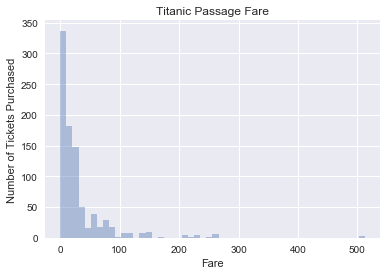

In [745]:
sns.distplot(train.Fare, kde=False)
plt.ylabel('Number of Tickets Purchased')
plt.title('Titanic Passage Fare')

In [746]:
train=pd.get_dummies(train, columns=['Sex'], prefix=[''])
train['Male']=train['_male']
train.head()

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,_female,_male,Male
0,1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,0,1,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,1,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,1,0,0
4,5,0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,0,1,1


In [747]:
train=train.drop(['_female','_male'],1)
train.head()

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Male
0,1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,0
2,3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,0
4,5,0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,1


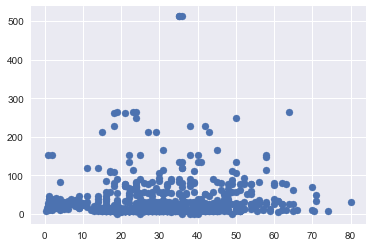

In [748]:
plt.scatter(train.Age,train.Fare)

In [562]:
plt.scatter(sorted(train.Ticket),train.Fare)
plt.xticks([])
plt.title("Distribution of Fare Price by Ticket No.", fontsize=16)
plt.xlabel("Sorted Ticket Numbers", fontsize=14)
plt.ylabel("Fare Price", fontsize=14)

ValueError: could not convert string to float: 'A./5. 2152'

ValueError: could not convert string to float: 'A./5. 2152'

In [749]:
train.isnull().any()

PassengerId    False
Survived       False
Pclass         False
Name           False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare           False
Male           False
dtype: bool

It appears that only Age contains missing values.  I will fill missing values for age with the median.  Choosing the median over the mean involves making the assumption that those with no age reported are more likely to be around the middle of the distribution than skewed left or right towards outliers (the very young and very old).  Because I supect that those with no age reported are most likely to be men old enough and healthy enough to be traveling alone I consider this to be a reasonable assumption.

In [750]:
train['Age']=train['Age'].fillna(train['Age'].median())

In [751]:
train['Age'].value_counts(dropna=False)

28.00    202
24.00     30
22.00     27
18.00     26
19.00     25
30.00     25
21.00     24
25.00     23
36.00     22
29.00     20
32.00     18
27.00     18
35.00     18
26.00     18
16.00     17
31.00     17
34.00     15
20.00     15
23.00     15
33.00     15
39.00     14
17.00     13
42.00     13
40.00     13
45.00     12
38.00     11
50.00     10
2.00      10
4.00      10
47.00      9
        ... 
71.00      2
59.00      2
63.00      2
0.83       2
30.50      2
70.00      2
57.00      2
0.75       2
13.00      2
10.00      2
64.00      2
40.50      2
32.50      2
45.50      2
20.50      1
24.50      1
0.67       1
14.50      1
0.92       1
74.00      1
34.50      1
80.00      1
12.00      1
36.50      1
53.00      1
55.50      1
70.50      1
66.00      1
23.50      1
0.42       1
Name: Age, Length: 88, dtype: int64

I believe that I can leverage my data better by creating dummy variables that describe particular subsets of my current stock of variables.  Infants, for instance, may be particularly unlikely to survive the titanic.  I will create dummy variables describing infants and the elderly.

In [752]:
pd.options.mode.chained_assignment = None

In [753]:
train['Infant']=0
train['Infant'][train.Age < 1] = 1
train['Elderly']=1
train['Elderly'][train.Age < 60] = 0

In [754]:
train['Infant'].value_counts()

0    884
1      7
Name: Infant, dtype: int64

In [755]:
train['Elderly'].value_counts()

0    865
1     26
Name: Elderly, dtype: int64

In [756]:
train.head()

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Male,Infant,Elderly
0,1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,1,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,0,0,0
2,3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,0,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,0,0,0
4,5,0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,1,0,0


## Modeling

In [757]:
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, classification_report, accuracy_score, mean_squared_error

In [758]:
target = train['Survived']
train=train.drop(['PassengerId', 'Survived','Ticket','Name'], axis=1)

In [759]:
scaler = StandardScaler()
scaler.fit(train) #learns mean and std dev for each variable
scaled_train = scaler.transform(train) #Subtracts mean and divides by std dev.

In [760]:
train = pd.DataFrame(data=scaled_train, columns=train.columns)

In [761]:
X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=.20, random_state=47)

### K-Neighbors

In [762]:
kn_class = KNeighborsClassifier()
gridsearch = GridSearchCV(kn_class, {"n_neighbors": [1, 3, 5, 7, 9, 11], "weights": ['uniform', 'distance'], 
                                'p': [1, 2, 3]}, scoring='f1')
gridsearch.fit(X_train, y_train)
print("Best Params: {}".format(gridsearch.best_params_))
y_pred_train = gridsearch.predict(X_train)
y_pred_test = gridsearch.predict(X_test)
#print("Train F1: {}\tTest F1: {}".format(accuracy_score(y_train, y_pred_train),accuracy_score(y_test, y_pred_test))

Best Params: {'n_neighbors': 7, 'p': 1, 'weights': 'distance'}


In [763]:
print(accuracy_score(y_train, y_pred_train))

0.97893258427


In [764]:
print(accuracy_score(y_test, y_pred_test))

0.759776536313


Not bad!  Let's see what Random Forest can do.

### Random Forest

In [765]:
from sklearn.ensemble import RandomForestClassifier

#predictor_cols = ['LotArea', 'OverallQual', 'YearBuilt', 'TotRmsAbvGrd']

#train_X = X_train[predictor_cols]

forest_class = RandomForestClassifier()
forest_class.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [766]:
predicted_survival = forest_class.predict(X_test)
predicted_survival

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1,
       1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1])

In [767]:
print(accuracy_score(y_test,predicted_survival))

0.793296089385


Even better!  I think we have something we can submit.

## Submission

In [768]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [769]:
test_id=test['PassengerId']

In [770]:
test_id.shape

(418,)

Now I will apply the same cleaning process I did with the training data to the test set.

In [771]:
test=test.drop(['Cabin','Embarked'],axis=1)
test=pd.get_dummies(test, columns=['Sex'], prefix=[''])
test['Male']=test['_male']
test=test.drop(['_female','_male'],1)
test['Age']=test['Age'].fillna(test['Age'].median())
test['Infant']=0
test['Infant'][test.Age < 1] = 1
test['Elderly']=1
test['Elderly'][test.Age < 60] = 0
test=test.drop(['PassengerId', 'Ticket','Name'], axis=1)
test['Fare']=test['Fare'].fillna(test['Fare'].median())

In [772]:
test.isnull().any()

Pclass     False
Age        False
SibSp      False
Parch      False
Fare       False
Male       False
Infant     False
Elderly    False
dtype: bool

In [773]:
forest_class.fit(X_train, y_train)
predicted_Titanic = forest_class.predict(test)

In [774]:
submission.shape

(418, 1)

In [775]:
predicted_Titanic.shape

(418,)

In [776]:
submission = test_id.to_frame()
submission['Survived'] = predicted_Titanic

In [777]:
submission.to_csv("Titanic_Submission2.csv", index=False)